In [27]:
# from database / __init__.py


__all__ = ["load_song_db",
           "clear",
           "add_songs",
           "switch_db",
           "list_songs",
           "remove_song"]


def load_song_db(func=None):
    """ This function can be invoked directly to lazy-load the song-recognition database, or it can
    be used as a decorator: the database is lazy-loaded prior to invoking the decorated function.

    See face_rec.face_db._load for more information.

    Parameters
    ----------
    func : Optional[Callable]

    Returns
    -------
    Union[None, Callable]"""
    if func is None:
        database.load()
        return None

    from functools import wraps

    @wraps(func)
    def wrapper(*args, **kwargs):
        database.load()
        return func(*args, **kwargs)
    return wrapper


def switch_db(path=None):
    """ Switch the song database being used by specifying its load/save path. Calling this
    function with no argument will revert to the default database.

    Providing a name with no directories will assume songfp/database as the directory,
    otherwise the provided path is used. All databases will be saved as .pkl files.

    Parameters
    ----------
    path : PathLike"""
    database.switch_db(path)


@load_song_db
def clear(x: bool):
    """ Clear the song database.

    You must subsequently run `songfp.save_song_database()` to save this change.

    Parameters
    ----------
    x : bool
        Pass True explicitly to confirm that you want to clear the database."""
    assert x is True
    database.clear()


def save():
    """ Save the database."""
    database.save()


@load_song_db
def add_songs(songs, names=None, artists=None):
    """ Add songs to the fingerprinting database

        Parameters
        ----------
        songs : Union[str, Iterable[str]]
           File path(s) to .mp3, .wav, (and maybe other formats) file(s) to be added.

        names : Optional[Sequence[Union[str, None]]]
           Corresponding song names. If `None` is provided, the dong name is inferred from
           the filename.

        artists : Optional[Sequence[Union[str, None]]]
           Corresponding song artists.

        Notes
        -----
        `add_songs_to_database('path/to/song/SongTitle.mp3')` will log this song in the database
        under the title 'SongTitle'. """
    database.add_songs(songs, names=names, artists=artists)


@load_song_db
def list_songs():
    return database.list_songs()


@load_song_db
def remove_song(name, artist=None):
    database.remove_song(name, artist)


In [28]:
# from _defaults.py

"""
Stores the globally-used default configuration values associated with sampling and fingerprinting the audio files
"""

# The target sampling rate used to read in an audio file
SAMPLING_RATE: int = 44100

# The fractional portion of intensities for which the cutoff is selected.
# E.g. frac_cut=0.8 will produce a cutoff intensity such that the bottom 80%
# of intensities are excluded.
MIN_FRAC_AMP_CUTOFF: float = 0.77

# The neighborhood radius used for determining if a spectrogram value
# is a local peak. Specified in spectrogram cells.
LOCAL_PEAK_NN_RADIUS: int = 20

# Given a spectrogram peak, indicates the maximum number of subsequent peaks to
# be used to form fingerprint features.
FINGERPRINT_FANOUT: int = 15
    

In [29]:
import pickle
from collections import abc, defaultdict
from pathlib import Path
from typing import Dict, List, NamedTuple, Optional, Sequence, Tuple, Union

import librosa

PathLike = Union[str, Path]


class Song(NamedTuple):
    song_name: str
    artist: str


class Database:
    """Stores the audio fingerprints associated with songs that have been added to the database"""

    def __init__(self):
        
        # cwd == current working directory: 
        cwd = Path().resolve()
        self.default_path = cwd / "song_db.pkl"

        self.path: Path = self.default_path
        self.song_list_path = self.path / "_song_list.pkl"

        # See `self.pair_mapping` for details
        self._pair_mapping: Dict[
            Tuple[int, int, int], List[Tuple[int, int]]
        ] = defaultdict(list)

        self._song_list: List[Optional[Tuple[str, Optional[str]]]] = []

        self._loaded = False

    @property
    def song_list(self) -> List[Optional[Tuple[str, Optional[str]]]]:
        """A list of (song-name, artist)

        Items should not be removed from this list! The song-ID in the
        database corresponds to the index of that song's name in this list.
        Instead, a song is removed by replacing its tuple with None"""
        return list(self._song_list)

    @property
    def pair_mapping(self) -> Dict[Tuple[int, int, int], List[Tuple[int, int]]]:
        """Stores the mapping: (f1, f2, dt) -> [(song-ID, t1), ...] where
        (f1, f2, dt) are the frequencies of two peaks and dt is their
        separation in time. [(song-ID, t1), ...] is the list of all song-IDs
        that contain this "fingerprint feature", along with the time at which it
        occurs.

        Note that all frequencies and times are quantized using histogram binning.
        Thus we are able to record an integer - indicating the histogram bin
        location - for each of these values. Multiplying by the bin size will thus
        convert each integer to the corresponding physical quantity"""
        return self._pair_mapping

    def __len__(self) -> int:
        return len(self._song_list)

    def clear(self):
        """Clears the database"""
        self._pair_mapping.clear()
        self._song_list = []
        self._loaded = False

    def switch_db(self, path: Optional[PathLike] = None):
        """Switch the song database being used by specifying its load/save path. Calling this
        function with no argument will revert to the default database.

        Providing a name with no directories will assume songfp/database as the directory,
        otherwise the provided path is used. All databases will be saved as .pkl files.

        Parameters
        ----------
        path : PathLike"""

        _backup_db = self._pair_mapping
        _backup_path = self.path
        _loaded = self._loaded

        try:
            if path is not None:
                path = Path(path).resolve()
                parent = (
                    path.parent if str(path.parent) != "." else self.default_path.parent
                )
                self.path = parent / (path.stem + ".pkl")
                assert self.path.parent.exists(), f"{self.path.parent} doesn't exist"
            else:
                self.path = self.default_path
            self._loaded = False
            self._pair_mapping = defaultdict(list)
            self.load()

        except Exception as e:
            print("The following error occurred: {}".format(e))
            print(
                "\nReverting to your prior database state at: {}".format(
                    _backup_path.absolute()
                )
            )
            self._pair_mapping = _backup_db
            self.path = _backup_path
            self._loaded = _loaded
            raise e

    def load(self, force: bool = False):
        """Load the database from songfp/database/song_db.pkl if it isn't
        already loaded.

        Call this if you want to load the database up front. Otherwise,
        the other database methods will automatically load it.

        Parameters
        ----------
        force : bool, optional (default=False)
            If `True` the database will be loaded again, even if it
            is already in-memory."""
        if not force and self._loaded:
            return

        if not self.path.is_file():
            print(
                "No song database found. Creating empty database...\n"
                "\tSaving it will save to {}".format(self.path.absolute())
            )
            self._pair_mapping = defaultdict(list)
            self._song_list = []
        else:
            with self.path.open(mode="rb") as f:
                data = pickle.load(f)

            assert isinstance(
                data, defaultdict
            ), f"the loaded database should be a defaultdict, got: {data}"

            self._pair_mapping = data

            with (self.path.parent / (self.path.stem + "_song_list.pkl")).open(
                mode="rb"
            ) as f:
                song_list = pickle.load(f)

            assert isinstance(
                song_list, list
            ), f"the loaded song_list should be a list, got: {song_list}"

            self._song_list = song_list
            print("song database loaded from: {}".format(self.path.absolute()))
        self._loaded = True

    def remove_song(self, name: str, artist: Optional[str] = None):
        try:
            # do not delete items from song list. song_id in database
            # is determined by song's position in song list. Removing
            # song will create offset in results.
            song_id = self._song_list.index((name, artist))
            self._song_list[song_id] = None

            for key, value in self._pair_mapping.items():
                self._pair_mapping[key] = [x for x in value if x[0] != song_id]

            print("{} removed from database. Be sure to save.".format((name, artist)))
        except ValueError:
            print("{} not in database".format((name, artist)))

    def save(self):
        if self._pair_mapping is None:
            print("No changes to face-database to save")
            return None

        with self.path.open(mode="wb") as f:
            pickle.dump(self._pair_mapping, f)

        with (self.path.parent / (self.path.stem + "_song_list.pkl")).open(
            mode="wb"
        ) as f:
            pickle.dump(self._song_list, f)

        print("Song database saved to: {}".format(self.path.absolute()))

    def add_songs(
        self,
        songs: Union[Path, Sequence[Path]],
        names: Optional[Sequence[str]] = None,
        artists: Optional[Sequence[str]] = None,
        *,
        sampling_rate: int = SAMPLING_RATE,
        min_frac_amp_cutoff: float = MIN_FRAC_AMP_CUTOFF,
        local_peak_nn_radius: int = LOCAL_PEAK_NN_RADIUS,
        fingerprint_fanout: int = FINGERPRINT_FANOUT,
    ):
        """Add songs to the fingerprinting database

        Parameters
        ----------
        songs : Union[Path, Iterable[Path]]
           File path(s) to .mp3, .wav, (and maybe other formats) file(s) to be added.

        names : Optional[Sequence[str | None]]
           Corresponding song names. If `None` is provided, the song name is inferred from
           the filename.

        artists : Optional[Sequence[str | None]]
           Corresponding song artists.

        sampling_rate: int, optional (default=_defaults.SAMPLING_RATE)
            The target sampling rate used to read in an audio file.

        min_frac_amp_cutoff: float, optional (default=_defaults.MIN_FRAC_AMP_CUTOFF)
            The fractional portion of intensities for which the cutoff is selected.
            E.g. frac_cut=0.8 will produce a cutoff intensity such that the bottom 80%
            of intensities are excluded.

        local_peak_nn_radius: int, optional (default=_defaults.LOCAL_PEAK_NN_RADIUS)
            The neighborhood radius used for determining if a spectrogram value
            is a local peak. Specified in spectrogram cells.

        fingerprint_fanout: int, optional (default=_defaults.FINGERPRINT_FANOUT)
            Given a spectrogram peak, indicates the maximum number of subsequent peaks to
            be used to form fingerprint features.

        Notes
        -----
        `add_songs('path/to/song/SongTitle.mp3')` will log this song
        in the database under the title 'SongTitle'."""

        if isinstance(songs, str):
            songs = [songs]

        if names is not None:
            assert isinstance(names, abc.Sequence) and len(names) == len(songs)
        else:
            names = [None] * len(songs)

        if artists is not None:
            assert isinstance(artists, abc.Sequence) and len(artists) == len(songs)
        else:
            artists = [None] * len(songs)

        old_num = len(self._song_list)

        for file_path, name, artist in zip(songs, names, artists):
            song_id = len(self._song_list)
            if name is None:
                name = Path(file_path).name

            if (name, artist) in self._song_list:
                print("{} already in song database. Skipping song.".format(name))
                continue
            print("adding {}..".format(name))

            digital, fs = librosa.load(file_path, sr=sampling_rate, mono=True)
            peaks = local_peaks(
                *digital_to_spec(digital, fs, frac_cut=min_frac_amp_cutoff),
                p_nn=local_peak_nn_radius,
            )

            for f1_f2_dt, t1 in peaks_to_fingerprints(
                peaks, fan_value=fingerprint_fanout
            ):
                self._pair_mapping[f1_f2_dt].append((song_id, t1))

            self._song_list.append((name, artist))

        if len(self._song_list) - old_num:
            print(
                "{} songs added to the database. "
                "\n\nBe sure to run `songfp.database.save()".format(
                    len(self._song_list) - old_num
                )
            )

    def list_songs(self) -> List[Song]:
        sorted_song = sorted(x for x in self._song_list if x is not None)
        return [Song(*x) for x in sorted_song]


database = Database()



In [30]:
# from functions.py

import numpy as np
import random
from collections import Counter
from typing import Dict, Iterable, List, Sequence, Tuple, TypeVar

import matplotlib.mlab as mlab
# import numpy as np
from matplotlib.pyplot import Axes, Figure
from numba import njit
from scipy.ndimage.morphology import generate_binary_structure, iterate_structure

SongID = TypeVar("SongID")


def rand_clip(digital: np.ndarray, new: float, fs: int = 44100) -> np.ndarray:
    """Produce a random "clip" of a digital signal

    Parameters
    ----------
    digital : numpy.ndarray, shape=(T, )
        digital signal to be clipped

    new : float
        The duration (seconds) of the resulting clip

    fs : int, optional (default=44100)
        The sampling rate of the digital signal

    Returns
    -------
    digital : numpy.ndarray, shape=(T_clipped, )
        Clipped digital signal, sampled from a random starting point"""
    if new is None:
        return digital

    old = len(digital)
    new = int(round(new * fs))
    assert 0 < new <= old
    start = random.randint(0, old - new - 1)
    return digital[start : start + new]


def digital_to_spec(
    digital: np.ndarray, fs: float, frac_cut: float, plot: bool = False
) -> Union[
    Tuple[np.ndarray, float], Tuple[np.ndarray, float, Figure, Axes, float, float]
]:
    """Produces a spectrogram and a cut-off intensity to yield the
    specified fraction of data.

    Parameters
    ----------
    digital : numpy.ndarray, shape=(Ts, )
        The sampled audio-signal.

    fs : float
        The sample-frequency used to create the digital signal.

    frac_cut : float
        The fractional portion of intensities for which the cutoff is selected.
        E.g. frac_cut=0.8 will produce a cutoff intensity such that the bottom 80%
        of intensities are excluded.

    plot : bool
        If True, produce a plot of the spectrogram and return the
        matplotlib fig & ax objects.

    Returns
    -------
    Union[Tuple[numpy.ndarray, float]]
        The spectrogram and the desired cutoff

        If plot=True, then: (spectrogram, cutoff, fig, ax, df, dt)
        is returned. Where (fig, ax) are the plot objects, and df
        and dt are the frequency and time units associated with the
        spectrogram bins.

    Notes
    -----
    One can identify a sensible threshold percentile by consulting the CDF
    of an ensemble of song spectrograms.
    """
    assert 0.0 <= frac_cut <= 1.0

    kwargs = dict(NFFT=4096, Fs=fs, window=mlab.window_hanning, noverlap=int(4096 / 2))
    if not plot:
        S, freqs, times = mlab.specgram(digital, **kwargs)
    else:
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots()
        S, freqs, times, im = ax.specgram(digital, **kwargs)
        fig.colorbar(im)

    # log-scaled Fourier amplitudes have a much more gradual distribution
    # for audio data.
    np.clip(S, a_min=1e-20, a_max=None, out=S)
    np.log(S, out=S)

    # Compute percentile-based threshold amplitude; this is greatly optimized by
    # leveraging the apt numpy.partition function.
    cutoff_index = int(frac_cut * S.size)
    cutoff = np.partition(S.ravel(), cutoff_index)[cutoff_index]

    if not plot:
        return S, cutoff
    else:
        df = freqs[1] - freqs[0]
        dt = times[1] - times[0]
        return S, cutoff, fig, ax, df, dt


@njit()
def _peaks(
    data_2d: np.ndarray, rows: np.ndarray, cols: np.ndarray, amp_min: float
) -> List[Tuple[int, int]]:
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    rows : numpy.ndarray, shape-(N,)
        The 0-centered row indices of the local neighborhood mask
    
    cols : numpy.ndarray, shape-(N,)
        The 0-centered column indices of the local neighborhood mask
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location. 
    """
    
    peaks = []  # stores the (row, col) locations of all the local peaks

    # Iterate over the 2-D data in col-major order
    # we want to see if there is a local peak located at
    # row=r, col=c
    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            # The amplitude falls beneath the minimum threshold
            # thus this can't be a peak.
            continue
        
        # Iterating over the neighborhood centered on (r, c)
        # dr: displacement from r
        # dc: discplacement from c
        for dr, dc in zip(rows, cols):
            if dr == 0 and dc == 0:
                # This would compare (r, c) with itself.. skip!
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                # neighbor falls outside of boundary
                continue

            # mirror over array boundary
            if not (0 <= c + dc < data_2d.shape[1]):
                # neighbor falls outside of boundary
                continue

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                # One of the amplitudes within the neighborhood
                # is larger, thus data_2d[r, c] cannot be a peak
                break
        else:
            # if we did not break from the for-loop then (r, c) is a peak
            peaks.append((r, c))
    return peaks


def local_peaks(
    log_spectrogram: np.ndarray, amp_min: float, p_nn: int
) -> List[Tuple[int, int]]:
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the
    specified `amp_min`.

    Parameters
    ----------
    log_spectrogram : numpy.ndarray, shape=(n_freq, n_time)
        Log-scaled spectrogram. Columns are the periodograms of
        successive segments of a frequency-time spectrum.

    amp_min : float
        Amplitude threshold applied to local maxima

    p_nn : int
        The neighborhood radius used for determining if a spectrogram value
        is a local peak. Specified in spectrogram cells.

    Returns
    -------
    List[Tuple[int, int]]
        Time and frequency index-values of the local peaks in spectrogram.
        Sorted by ascending frequency and then time.

    Notes
    -----
    The local peaks are returned in column-major order for the spectrogram.
    That is, the peaks are ordered by time. That is, we look for nearest
    neighbors of increasing frequencies at the same times, and then move to
    the next time bin.
    """
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, p_nn)
    rows, cols = np.where(neighborhood)
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1

    # center neighborhood indices around center of neighborhood
    rows -= neighborhood.shape[0] // 2
    cols -= neighborhood.shape[1] // 2

    # Note that even though we are dealing with native python ints, which
    # are unsized and have 24 *bytes* reserved for them, it is actually
    # more efficient (by a factor of ~4x !!) to pickle python-ints instead
    # of numpy.int16 objects. I think this is because of the additional
    # metadata associated with saving numpy objects.
    detected_peaks = _peaks(log_spectrogram, rows, cols, amp_min=amp_min)

    # Extract peaks; encoded in terms of time and freq bin indices.
    # dt and df are always the same size for the spectrogram that is produced,
    # so the bin indices consistently map to the same physical units:
    # t_n = n*dt, f_m = m*df (m and n are integer indices)
    # Thus we can codify our peaks with integer bin indices instead of their
    # physical (t, f) coordinates. This makes storage and compression of peak
    # locations much simpler.

    return detected_peaks


def peaks_to_fingerprints(
    peaks: Sequence[Tuple[int, int]], fan_value: int
) -> Iterable[Tuple[Tuple[int, int, int], int]]:
    """Given the time-frequency locations of spectrogram peaks, generates
    'fingerprint' features.

    Parameters
    ----------
    peaks : Sequence[Tuple[int, int]]
        A sequence of time-frequency pairs

    fan_value : int1
        Given a peak, `fan_value` indicates the number of subsequent peaks
        to be used to form fingerprint features.

    Yields
    ------
    Tuple[Tuple[int, int, int], int]
        ((f_{n}, f_{n+j}, t_{n+j} - t_{n}), t_{n})
        The frequency value of peak n, peak n+j, their time-offset, along with the
        time at which peak n occurred."""

    assert 1 <= fan_value
    for n, (t1, f1) in enumerate(peaks):
        for t2, f2 in peaks[n + 1 : n + fan_value + 1]:
            yield (f1, f2, t2 - t1), t1


def fingerprints_to_matches(
    sample_fingerprints: Iterable[Tuple[Tuple[int, int, int], int]],
    database: Dict[Tuple[int, int, int], List[Tuple[SongID, int]]],
) -> Tuple[SongID, int]:
    """Generates database matches from all of a sample's fingerprints.

    Parameters
    ----------
    sample_fingerprints : Iterable[Tuple[Tuple[int, int, int], int]]
        ((f_{n}, f_{n+j}, dt), t_{n})
        The frequency value of peak n and peak n+j, along with the time at which peak n occurred.

    database : Dict[Tuple[int, int, int], List[Tuple[Any, int]]
        (freq_{n}, freq_{n+j, dt} -> [(song_ID, t), ... ]
        A dictionary that maps frequency peak-pairs and their offset to a list of all the
        song IDs containing that signature, and the time at which the signature occurred
        in the song.

    Yields
    ------
    Tuple[song_ID, dt]
        A song ID that had a matching peak-pair signature, and the time offset between when
        the signature occurred in the song versus the sample."""
    for f1_f2_dt, t_sample in sample_fingerprints:
        o = database.get(f1_f2_dt)
        if o is not None:
            for s_id, t_song in o:
                yield s_id, t_song - t_sample


def matches_to_best_match(matches: Iterable[Tuple[SongID, float]]) -> SongID:
    """Determines the song-ID that has the most consistent fingerprint-offset

    Parameters
    ----------
    matches : Iterable[Tuple[song_ID, dt]]
        A song-ID that had a match with the sample, and the time-offset between their
        matching signatures.

    Returns
    -------
    SongID
        The song-ID with the most common time-offset with the sample."""
    cntr = Counter(matches)
    if not cntr:
        return None

    item, cnt = cntr.most_common(1)[0]
    return item[0]


In [41]:
from pathlib import Path
from typing import Tuple, Union

import numpy as _np
from matplotlib.pyplot import Axes, Figure

import librosa as _librosa
from microphone import record_audio

def get_digital_recording(time: float) -> Tuple[_np.ndarray, int]:
    """
    Get the digital samples and sampling rate of a microphone's recording.

    Parameters
    ----------
    time : float
        Time, in seconds to record from the mic.

    Returns
    -------
    Tuple[numpy.ndarray, int]
        The digital samples (mono: shape-(N,)) from the recording and
        the sampling rate used.
    """
    frames, sample_rate = record_audio(time)
    digital_data = _np.hstack([_np.frombuffer(i, _np.int16) for i in frames])
    return digital_data, sample_rate


@load_song_db
def match_recording(
    time: int,
    *,
    min_frac_amp_cutoff: float = MIN_FRAC_AMP_CUTOFF,
    local_peak_nn_radius: int = LOCAL_PEAK_NN_RADIUS,
    fingerprint_fanout: int = FINGERPRINT_FANOUT,
) -> str:
 
    #from .database import database
    sample_digital, fs = get_digital_recording(time)
    if not database:
        print("No songs to match - your _database is empty!")
        return "no match... your database is empty!"
    peaks = local_peaks(
        *digital_to_spec(sample_digital, fs, frac_cut=min_frac_amp_cutoff),
        p_nn=local_peak_nn_radius,
    )
    fingerprints = peaks_to_fingerprints(peaks, fan_value=fingerprint_fanout)
    matches = fingerprints_to_matches(fingerprints, database.pair_mapping)
    #print(matches)
    song_id = matches_to_best_match(matches)

    if song_id is None:
        return "no match..."

    name, artist = database.song_list[song_id]
    return name + ("" if artist is None else " by {}".format(artist))



def plot_song(
    song: Union[str, Path, _np.ndarray],
    with_peaks: bool = True,
    *,
    sampling_rate: int = SAMPLING_RATE,
    min_frac_amp_cutoff: float = MIN_FRAC_AMP_CUTOFF,
    local_peak_nn_radius: int = LOCAL_PEAK_NN_RADIUS,
) -> Tuple[Figure, Axes]:
    """Plot a spectrogram and fingerprint features for a song.

    Parameters
    ----------
    song : Union[str, pathlib.Path, numpy.ndarray]
        The filepath to a song-file, or the digital signal itself.

    with_peaks : bool
        If True, include peak-value scatter-points

    sampling_rate: int, optional (default=_defaults.SAMPLING_RATE)
        The target sampling rate used to read in an audio file

    min_frac_amp_cutoff: float, optional (default=_defaults.MIN_FRAC_AMP_CUTOFF)
        The fractional portion of intensities for which the cutoff is selected.
        E.g. frac_cut=0.8 will produce a cutoff intensity such that the bottom 80%
        of intensities are excluded.

    local_peak_nn_radius: int, optional (default=_defaults.LOCAL_PEAK_NN_RADIUS)
        The neighborhood radius used for determining if a spectrogram value
        is a local peak. Specified in spectrogram cells.

    Returns
    -------
    Tuple[matplotlib.pyplot.Figure, matplotlib.pyplot.Axes]"""
    from microphone.config import settings
    from pathlib import Path

    if isinstance(song, (str, Path)):
        digital, fs = _librosa.load(str(song), sr=sampling_rate, mono=True)
    elif isinstance(song, _np.ndarray):
        digital = song
        fs = settings.rate
    else:
        raise TypeError("`song` must be a path to a song or an audio signal array")
    S, cut, fig, ax, df, dt = digital_to_spec(
        digital, fs, frac_cut=min_frac_amp_cutoff, plot=True
    )

    if with_peaks:
        peaks = local_peaks(S, cut, p_nn=local_peak_nn_radius)
        t_loc, f_loc = zip(*peaks)
        # add shifts to times and freqs so that the peaks
        # align with the spectrogram image bins
        times = dt * (_np.array(tuple(t_loc)) + 1)
        freqs = df * (_np.array(tuple(f_loc)) + 0.5)
        ax.scatter(times, freqs, s=4, color="white")
        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("Frequency (Hz)")
    return fig, ax


def plot_recording(time: float, with_peaks: bool = True) -> Tuple[Figure, Axes]:
    """Plot a spectrogram and fingerprint features for a live recording

    Parameters
    ----------
    time : float
        The time, in seconds, for which the microphone will record the sample.

    with_peaks : bool
        If True, include peak-value scatter-points

    Returns
    -------
    Tuple[matplotlib.pyplot.Figure, matplotlib.pyplot.Axes]"""
    digital_data, _ = get_digital_recording(time)
    return plot_song(digital_data, with_peaks=with_peaks)


### Adding Songs to Fingerprint Database

In [32]:
# db.switch_db("tutorial1")
database.switch_db("AudioProject")

song database loaded from: C:\Users\nrabi\Documents\Audio_Project\AudioProject.pkl


You can call `songfp.database.switch_db()` with no argument to revert to the default database. Also, if you want to load a database at a specific instance, you can call `songfp.database.load_song_db`. This can be useful if you are deploying a service, and want to control when things load. Otherwise, the utilities provided by `songfp` will automatically lazy-load the database.

In [33]:
# empty database to start with
list_songs()

[Song(song_name='Little Wing', artist='Jimi Hendrix'),
 Song(song_name='Never Gonna Give You Up', artist='Rick Astley'),
 Song(song_name='Space Oddity', artist='David Bowie'),
 Song(song_name='Space Oddity Cover', artist='Chris Hadfield'),
 Song(song_name='The Phantom of the Opera', artist='Andrew Lloyd Webber')]

Simply indicate paths to song files (.mp3, .wav, and maybe other formats) that you want to add to the database. You can also provide the song name and artist, if you want the output of the song-recognition to be verbose.

In [34]:
from time import time
#database.remove_song('Space Oddity', 'David Bowie')

In [35]:
songs = [r"C:\Users\nrabi\Documents\Audio_Project\SongRecognition\MusicMP3s\David Bowie - Space Oddity.mp3", 
         r"C:\Users\nrabi\Documents\Audio_Project\SongRecognition\MusicMP3s\Jimi Hendrix - Little Wing.mp3", 
         r"C:\Users\nrabi\Documents\Audio_Project\SongRecognition\MusicMP3s\Rick Astley - Never Gonna Give You Up.mp3",
         r"C:\Users\nrabi\Documents\Audio_Project\SongRecognition\MusicMP3s\Andrew Lloyd Webber - The Music of the Night.mp3",
         r"C:\Users\nrabi\Documents\Audio_Project\Space Oddity - Chris Hadfield Cover.mp3"
        ]


names = ["Space Oddity", "Little Wing", "Never Gonna Give You Up", "The Phantom of the Opera", "Space Oddity Cover"]

artists = ["David Bowie", "Jimi Hendrix", "Rick Astley", "Andrew Lloyd Webber", "Chris Hadfield"]

start = time()
database.add_songs(songs, names, artists)
dt = time() - start
dt

Space Oddity already in song database. Skipping song.
Little Wing already in song database. Skipping song.
Never Gonna Give You Up already in song database. Skipping song.
The Phantom of the Opera already in song database. Skipping song.
Space Oddity Cover already in song database. Skipping song.


0.0

Save database to disk - database will be loaded in its present state the next time `songfp` is imported. Run `songfp.database.clear(True)` to delete the database from disk.

In [36]:
database.save()

Song database saved to: C:\Users\nrabi\Documents\Audio_Project\AudioProject.pkl


List the songs in the database:

In [37]:
database.list_songs()

[Song(song_name='Little Wing', artist='Jimi Hendrix'),
 Song(song_name='Never Gonna Give You Up', artist='Rick Astley'),
 Song(song_name='Space Oddity', artist='David Bowie'),
 Song(song_name='Space Oddity Cover', artist='Chris Hadfield'),
 Song(song_name='The Phantom of the Opera', artist='Andrew Lloyd Webber')]

### Listening for a Match
Once you have populated your fingerprint database, simply begin playing your music to your configured microphone, and run `match_recording(10)` to record a 10 second clip (10 seconds is recommended for reliable results).

In [38]:
match_recording(10)

Using input device 'Internal Microphone (AMD Audio'
Recording ended


'Little Wing by Jimi Hendrix'

### Plotting the Spectragram + Fingerprints

Using input device 'Internal Microphone (AMD Audio'
Recording ended


<IPython.core.display.Javascript object>


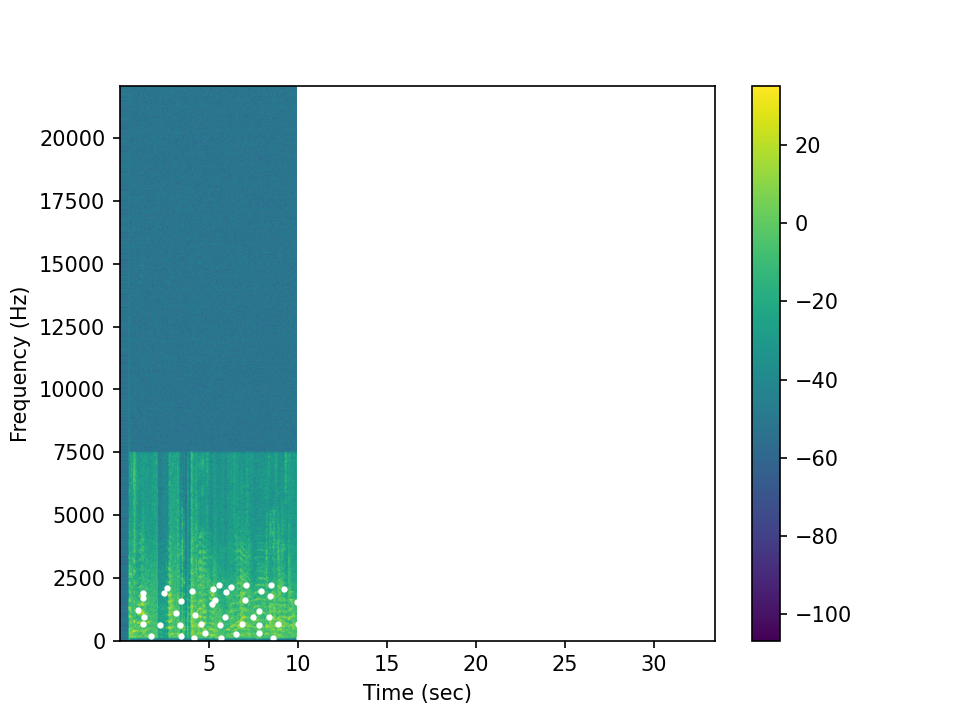

In [42]:
# make sure the plots render in the notebook
%matplotlib notebook 

# plot a 10 second recording
fig, ax = plot_recording(10)